## <center> CNN Exercise - Fashion MNIST </center>


### The Challenge

Your task is to build an image classifier with Keras and Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot
    

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='C:/Users/Lenovo/Desktop/Python/Deep Learnng/Data Sets', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets', train=False, download=True, transform=transform)

In [3]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

**TASK: Use DataLoader to create a <tt>train_loader</tt> and a <tt>test_loader</tt>. Batch sizes should be 10 for both.**

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

**TASK: Use DataLoader, <tt>make_grid</tt> and matplotlib to display the first batch of 10 images.**

tensor([2, 9, 8, 7, 3, 5, 5, 0, 0, 0])
['Sweater', 'Boot', 'Bag', 'Sneaker', 'Dress', 'Sandal', 'Sandal', 'T-shirt', 'T-shirt', 'T-shirt']


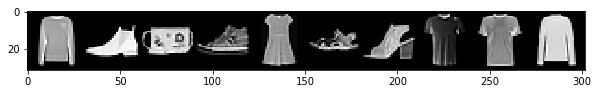

In [7]:
for images,labels in train_loader: 
    break

print(labels)
print([class_names[label] for label in labels])
im = make_grid(images[:10], nrow=10)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

**TASK**


Define a CNN model that can be trained on the Fashion-MNIST dataset. The model should contain two convolutional layers, two pooling layers, and two fully connected layers. You can use any number of neurons per layer so long as the model takes in a 28x28 image and returns an output of 10. Portions of the definition have been filled in for convenience.

In [8]:
conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
conv2 = nn.Conv2d(16, 25, kernel_size=2, stride=1, padding=0)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

convs = [conv1, conv2]
pools = [pool1, pool2]


def in_calculator(x, val):
    mult = val
    for ind, conv in enumerate(convs):
        x = conv(x)
        pool = pools[ind]
        x = pool(x)
    
    lis = list(x.shape)
    mult *= lis[-2]
    mult *= lis[-1]
    
    return mult

in_val = in_calculator(images, 25)



In [9]:
class CNNNet(nn.Module):

    def __init__(self, in_val=in_val, num_classes=10):
        super(CNNNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 25, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_val, 120),
            nn.ReLU(),

            nn.Linear(120, 84),
            nn.ReLU(),
            
            nn.Linear(84, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [10]:
torch.manual_seed(42)
model = CNNNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

CNNNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 25, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=900, out_features=120, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)

**TASK: What is the total number of trainable parameters (weights & biases) in the model above?**

In [11]:
tot = 0
for param in model.parameters():
    print(param.numel())
    tot += param.numel()

print("-------")

tot

144
16
1600
25
108000
120
10080
84
840
10
-------


120919

**TASK: Train the model**

In [12]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)

epoch:  0  batch:  600 [  6000/60000]  loss: 0.92631948  accuracy:  55.617%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.60383505  accuracy:  63.767%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 1.12108660  accuracy:  67.211%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.32326961  accuracy:  69.546%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.26291472  accuracy:  70.667%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.45802394  accuracy:  71.775%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 1.18401456  accuracy:  72.552%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.77519542  accuracy:  73.233%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.50687701  accuracy:  73.880%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.32643509  accuracy:  74.388%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.23070547  accuracy:  80.567%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.48686528  accuracy:  80.492%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.27427000  accuracy:  80.822%
epoch:  1  b

**TASK: Display the different graphs and the evaluation of the model**

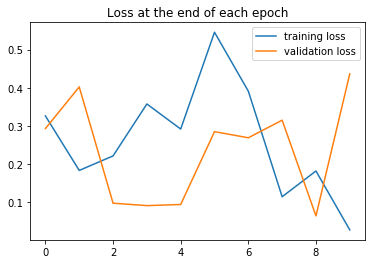

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [15]:
test_losses

[0.29331550002098083,
 0.40242260694503784,
 0.0980585366487503,
 0.09170635044574738,
 0.0946388691663742,
 0.2852928936481476,
 0.2692587971687317,
 0.31533557176589966,
 0.06487570703029633,
 0.4366435110569]

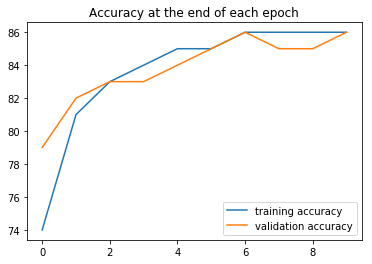

In [16]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [17]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8565/10000 =  85.650%


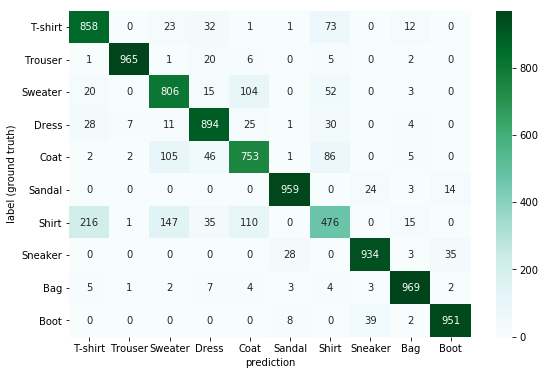

In [37]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();